In [1]:
import pandas as pd
import numpy as np
import os
from os.path import exists
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
sns.set_theme(style="dark")

In [2]:
CO2_URL = "https://gml.noaa.gov/aftp/products/trends/co2/co2_mm_gl.csv"
CO2_FILENAME = "co2_mm_gl.csv"
OCEAN_HEAT_URL = "https://www.ncei.noaa.gov/data/oceans/woa/DATA_ANALYSIS/3M_HEAT_CONTENT/DATA/basin/3month/ohc_levitus_climdash_seasonal.csv"
# https://www.ncei.noaa.gov/access/global-ocean-heat-content/basin_heat_data_monthly.html
OCEAN_HEAT_FILENAME = "ncei_global_ocean_heat.csv"

In [3]:
def process_ocean_heat(data_path="../data"):
    if not exists(data_path):
        os.makedirs(data_path)

    if not os.path.isfile(os.path.join(data_path, OCEAN_HEAT_FILENAME)):
        df_ocean = pd.read_csv(OCEAN_HEAT_URL, header=None)
        df_ocean.rename(columns={0: "Date", 1: "Temp"}, inplace=True)
        df_ocean.Date = pd.to_datetime(df_ocean.Date)
        df_ocean.set_index("Date", inplace=True)
        df_ocean.to_csv(os.path.join(data_path, OCEAN_HEAT_FILENAME))

    else:
        df_ocean = pd.read_csv(
            os.path.join(data_path, OCEAN_HEAT_FILENAME),
            index_col=["Date"],
            parse_dates=True,
        )

    return df_ocean

In [4]:
def process_co2(data_path="../data"):
    if not exists(data_path):
        os.makedirs(data_path)

    if not os.path.isfile(os.path.join(data_path, CO2_FILENAME)):
        df_co2 = pd.read_csv(CO2_URL, skiprows=38)
        df_co2['Date'] = pd.to_datetime(df_co2.assign(day=1)[['year', 'month', 'day']]) ### Update other file!!!
        df_co2.set_index("Date", inplace=True)
        df_co2.rename(columns={"average": "co2"}, inplace=True)
        df_co2 = df_co2[["co2"]]
        df_co2.to_csv(os.path.join(data_path, CO2_FILENAME))

    else:
        df_co2 = pd.read_csv(
            os.path.join(data_path, CO2_FILENAME), index_col=["Date"], parse_dates=True
        )

    return df_co2

In [5]:
df_ocean = process_ocean_heat()

In [6]:
df_co2 = process_co2()

## Ocean Heat

<Axes: xlabel='Date'>

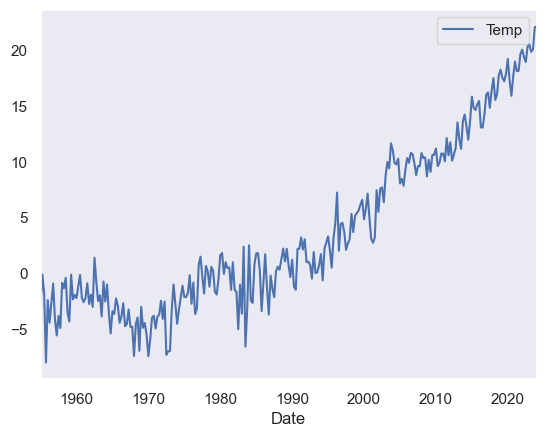

In [7]:
df_ocean.plot()

The residuals are heteroskedastic when using a multiplicative model, with variance decreasing. Additionally, we are adding 10 to the ocean heat values because this model only takes positive values, which makes our minimum roughly zero:

<Axes: xlabel='Date'>

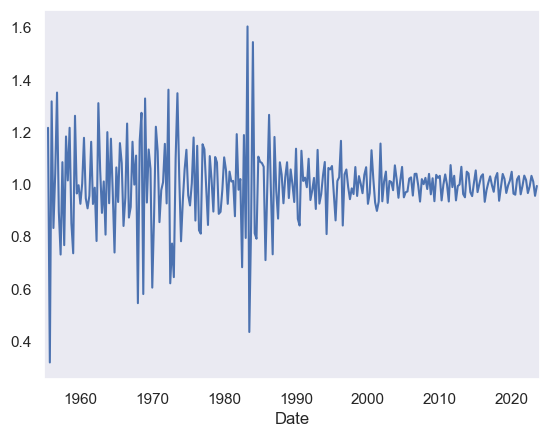

In [8]:
seasonal_decompose(df_ocean+10, model='multiplicative', period=4).resid.plot()

So we will be using the additive seasonal decomposition due to the residuals not exhibiting heteroskedasticity and also being stationary.

<Axes: xlabel='Date'>

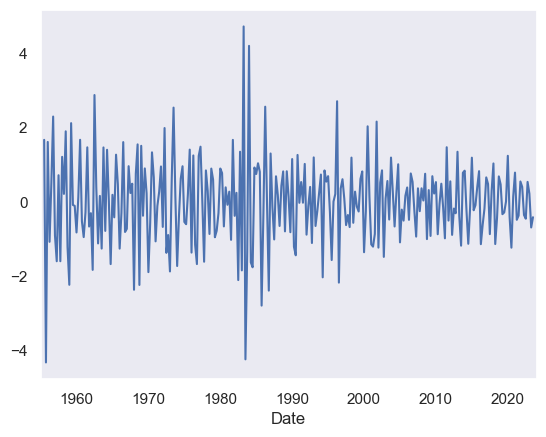

In [9]:
decomposition = seasonal_decompose(df_ocean, model='additive', period=4)

decomposition.resid.plot()

This matches the literature that ocean temperatures are slightly cooler during the northern hemisphere's winter:

In [10]:
decomposition.seasonal.head(4)

Date
1955-03-01    0.245203
1955-06-01    0.138639
1955-09-01   -0.339490
1955-12-01   -0.044352
Name: seasonal, dtype: float64

In [11]:
df_ocean2 = decomposition.trend + decomposition.resid
df_ocean2 = pd.DataFrame(df_ocean2)
df_ocean2.rename(columns={0: "Temp"}, inplace=True)
df_ocean2 = df_ocean2.dropna()

Ocean heat without seasonal component:

<Axes: xlabel='Date'>

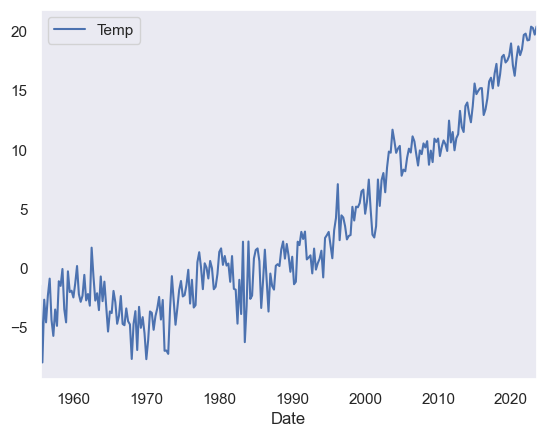

In [12]:
df_ocean2.plot()

Mean ocean temperature from 1970 to 2000:

In [13]:
df_ocean2.loc['1970-01-01':'1999-12-31'].mean()

Temp   -0.129543
dtype: float64

Subtracting the base period's mean:

In [14]:
df_ocean3 = df_ocean2 - df_ocean2.loc['1970-01-01':'1999-12-31'].mean()

<Axes: xlabel='Date'>

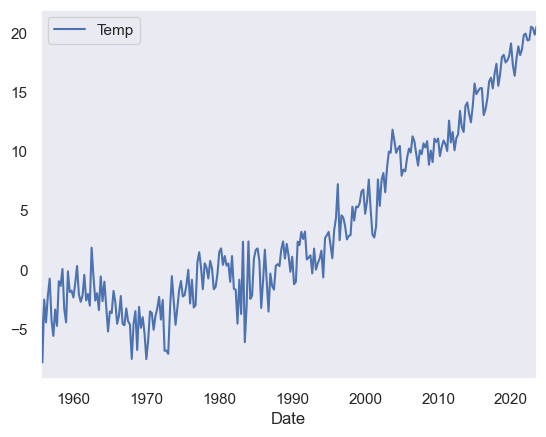

In [15]:
df_ocean3.plot()

Next we will be looking at annualized quarterly change.

In [16]:
df_ocean3_delta = df_ocean3.diff()*4
df_ocean3_delta = df_ocean3_delta.dropna()

<Axes: xlabel='Date'>

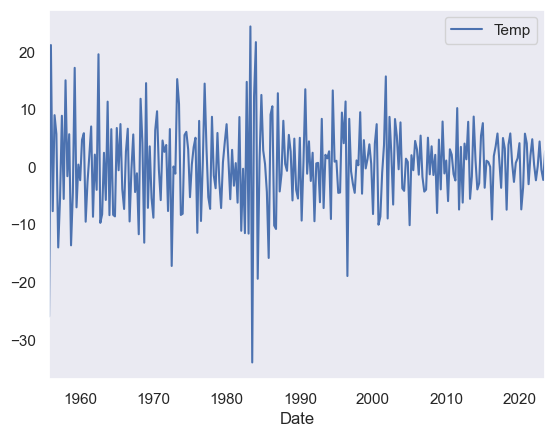

In [17]:
df_ocean3_delta.plot()

In [18]:
df_ocean3_delta.describe()

,Temp
count,272.000000
mean,0.321994
std,7.679899
min,-33.949866
25%,-4.450517
50%,0.733478
75%,4.973285
max,24.443196


array([[<Axes: title={'center': 'Temp'}>]], dtype=object)

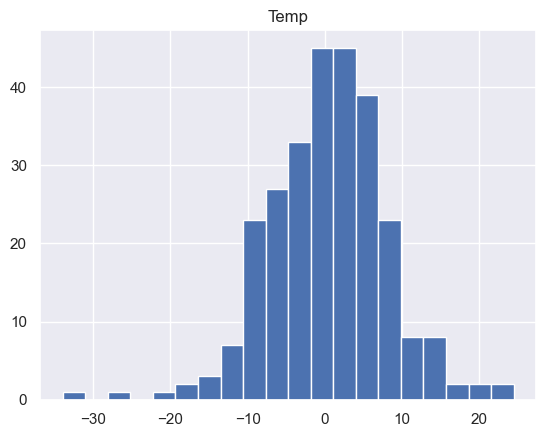

In [19]:
df_ocean3_delta.hist(bins=20)

We can see that there is leptokurtic and has a slight negative skew.

In [20]:
df_ocean3_delta['Temp'].kurtosis()

1.6840450673112346

In [21]:
df_ocean3_delta['Temp'].skew()

-0.24624343411256097

There is negative autocorrelation showing a reversion to the mean.

In [22]:
df_ocean3_delta['Temp'].autocorr()

-0.4016520116368409

In [23]:
df_ocean3_delta

,Temp
Date,
1955-12-01,-25.952015
1956-03-01,21.210502
1956-06-01,-7.658316
1956-09-01,9.027666
1956-12-01,5.745537
...,...
2022-09-01,0.186042
2022-12-01,4.452841
2023-03-01,-0.450822


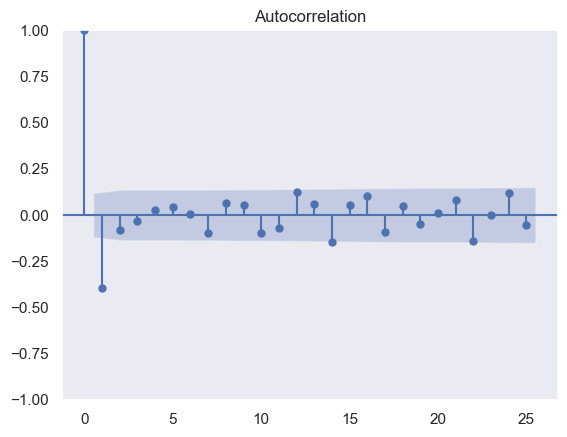

In [24]:
plot_acf(df_ocean3_delta['Temp'])
plt.show()


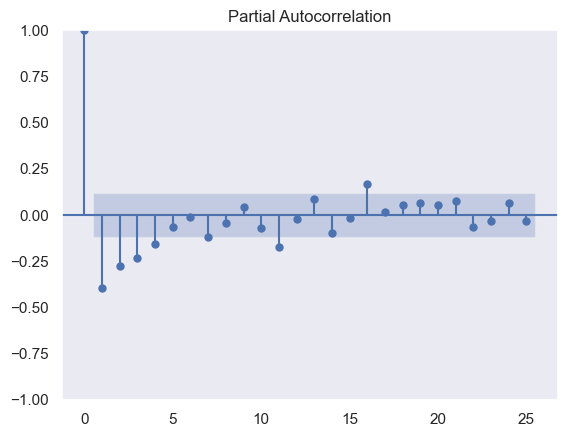

In [25]:
plot_pacf(df_ocean3_delta['Temp'])
plt.show()

Finally, we interpolate to get monthly values. As expected this is nearly identical to our monthly graph.

<Axes: xlabel='Date'>

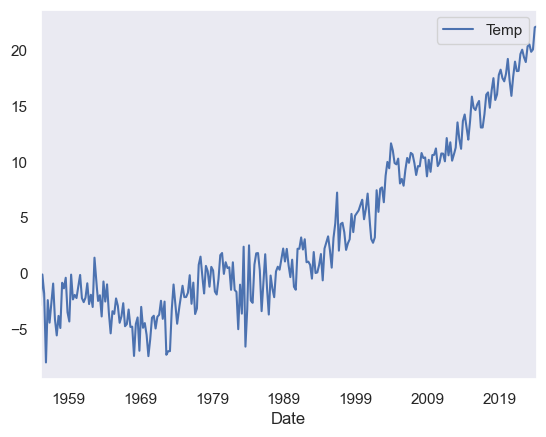

In [26]:
df_ocean_m = df_ocean.resample('MS').asfreq()
df_ocean_m['Temp'] = df_ocean_m['Temp'].interpolate(method='linear')
df_ocean_m.plot()

## CO2

<Axes: xlabel='Date'>

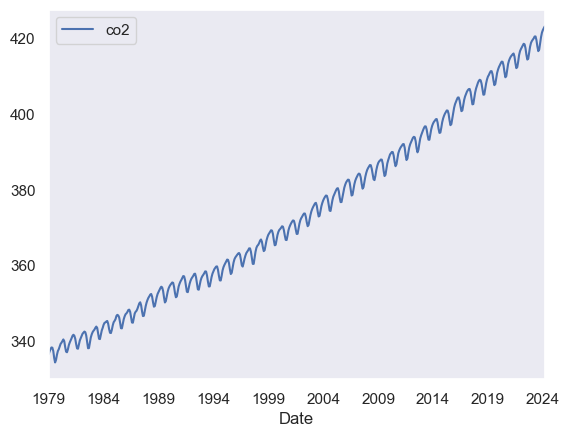

In [27]:
df_co2.plot()

In [28]:
df_co2

,co2
Date,
1979-01-01,336.56
1979-02-01,337.29
1979-03-01,337.88
1979-04-01,338.32
1979-05-01,338.26
...,...
2023-11-01,420.34
2023-12-01,421.54
2024-01-01,422.22


Because the in-year variation is not increasing over time, we are using additive seasonality.

<Axes: xlabel='Date'>

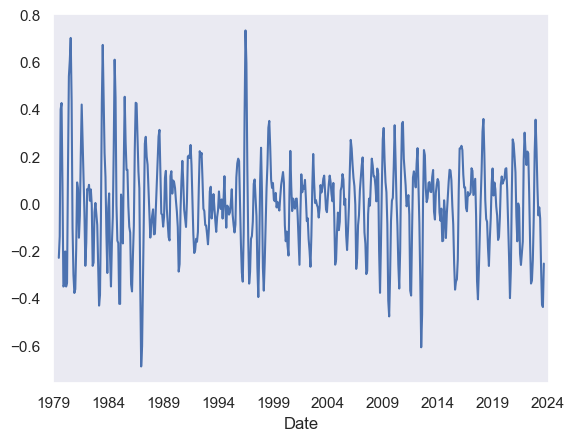

In [29]:
decomposition = seasonal_decompose(df_co2, model='additive', period=12)

decomposition.resid.plot()

In [30]:
decomposition.seasonal.head(12)

Date
1979-01-01    0.913881
1979-02-01    1.242801
1979-03-01    1.517886
1979-04-01    1.755623
1979-05-01    1.607915
1979-06-01    0.615538
1979-07-01   -1.143558
1979-08-01   -2.599725
1979-09-01   -2.630429
1979-10-01   -1.458279
1979-11-01   -0.270589
1979-12-01    0.448937
Name: seasonal, dtype: float64

In [31]:
df_co22 = decomposition.trend + decomposition.resid
df_co22 = pd.DataFrame(df_co22)
df_co22.rename(columns={0: "CO2"}, inplace=True)
df_co22 = df_co22.dropna()

Without the seasonal component, it is quite linear:

<Axes: xlabel='Date'>

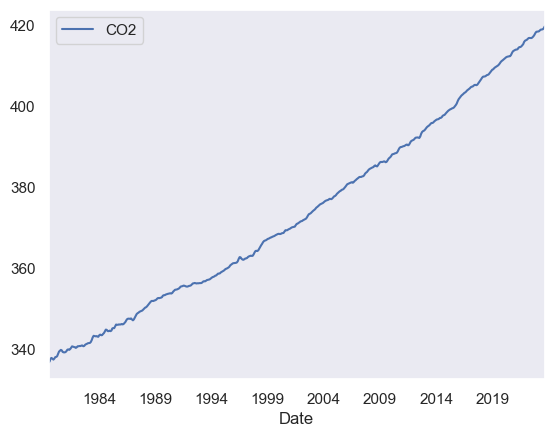

In [32]:
df_co22.plot()

In the paper they are taking the difference from 1970, since our dataset starts in 1979 we are taking the mean of the first five years of our sample.

In [33]:
df_co22.loc['1979-07-01':'1984-06-30'].mean()

CO2    340.5765
dtype: float64

In [34]:
df_co23 = df_co22 - df_co22.loc['1979-07-01':'1984-06-30'].mean()

<Axes: xlabel='Date'>

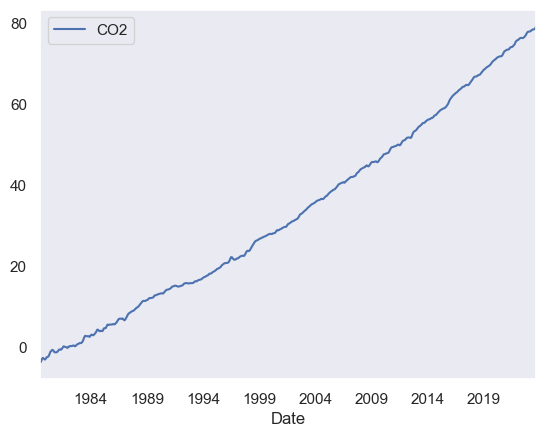

In [35]:
df_co23.plot()

Next, let's look at annualized monthly change.

In [36]:
df_co23_delta = df_co23.diff()*12
df_co23_delta = df_co23_delta.dropna()

It is stationary but with variable skedasticity (for example look at the mid-1990s).

<Axes: xlabel='Date'>

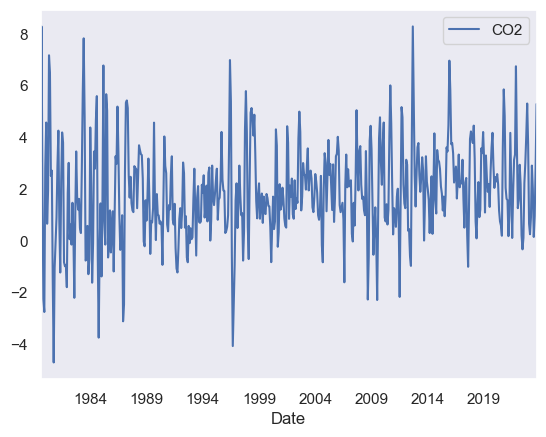

In [37]:
df_co23_delta.plot()

In [38]:
df_co23_delta.describe()

,CO2
count,530.000000
mean,1.878722
std,1.846367
min,-4.705803
25%,0.747301
50%,1.707443
75%,2.967875
max,8.288444


array([[<Axes: title={'center': 'CO2'}>]], dtype=object)

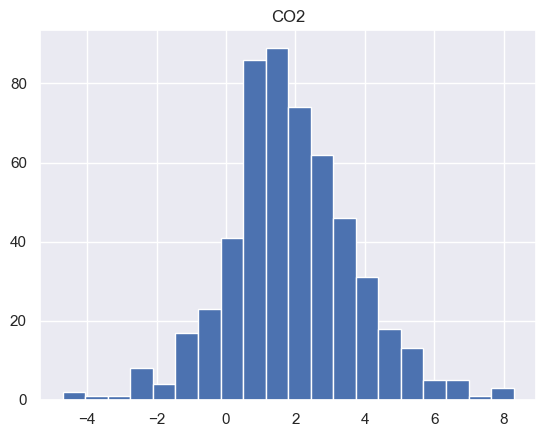

In [39]:
df_co23_delta.hist(bins=20)

We can see that there is leptokurtic and has a slight positive skew.

In [40]:
df_co23_delta['CO2'].kurtosis()

0.9511003837329053

In [41]:
df_co23_delta['CO2'].skew()

0.18551835670931724

There is positive autocorrelation showing positive feedback.

In [42]:
df_co23_delta['CO2'].autocorr()

0.4938714920561961

There appears to be a seasonal autocorrelation effect occuring. I verified that we are indeed using the de-seasonalized data. It occurs on a 12 month cycle.

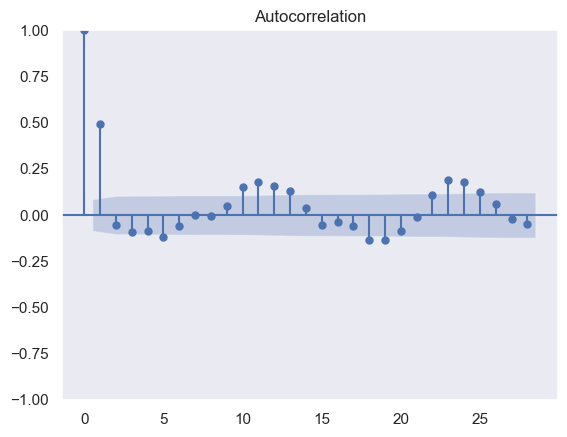

In [43]:
plot_acf(df_co23_delta['CO2'])
plt.show()

Looking at the ACF for before deseasonalization the effect is much starker:

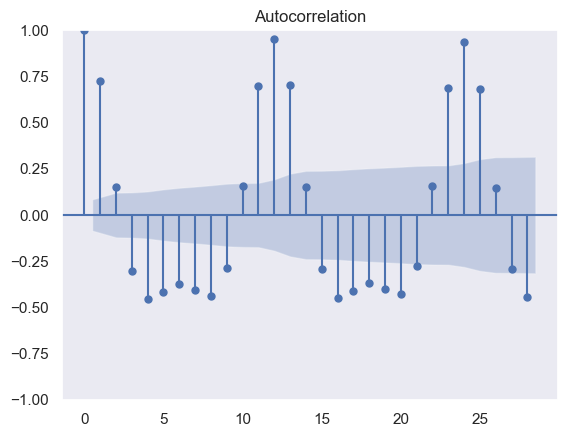

In [44]:
plot_acf(df_co2.diff().dropna())
plt.show()


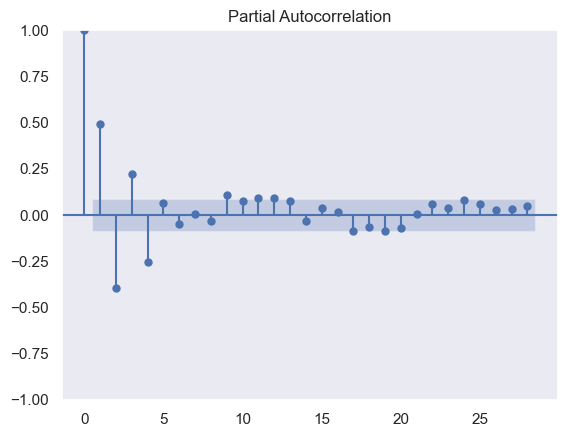

In [45]:
plot_pacf(df_co23_delta['CO2'])
plt.show()

## Both together

In [46]:
merged_df = pd.merge(df_ocean_m, df_co23, on='Date')

<Axes: xlabel='Date'>

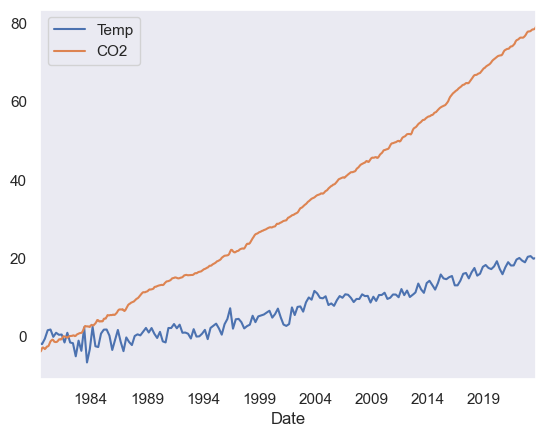

In [47]:
merged_df.plot()

In [48]:
merged_df

,Temp,CO2
Date,,
1979-07-01,-1.730219,-3.872942
1979-08-01,-1.819991,-3.616775
1979-09-01,-1.909762,-2.926071
1979-10-01,-1.450747,-2.758221
1979-11-01,-0.991733,-2.945911
...,...,...
2023-05-01,20.090753,78.335585
2023-06-01,19.869020,78.347962
2023-07-01,19.939857,78.427058


There is not an interesting relationship between the two because both are increasing over time:

<Axes: xlabel='Temp', ylabel='CO2'>

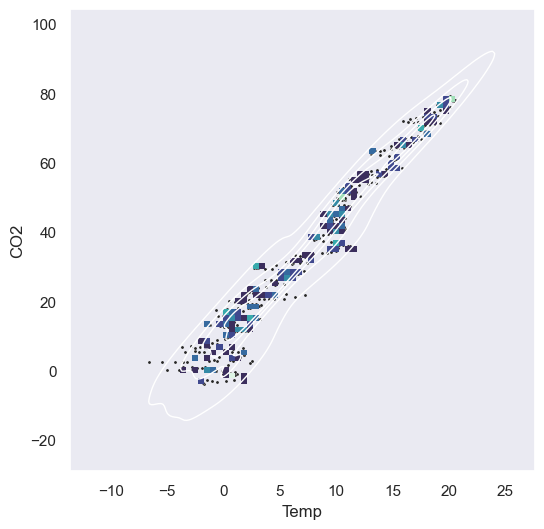

In [49]:
x = merged_df['Temp']
y = merged_df['CO2']

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

Additionally, when taking first differences again we do not see a relationship:

<Axes: xlabel='Temp', ylabel='CO2'>

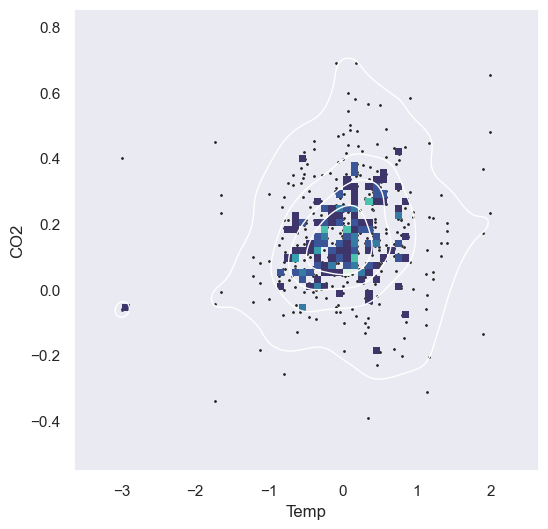

In [50]:
x = merged_df['Temp'].diff()
y = merged_df['CO2'].diff()

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)